In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("Airline_Delay_Cause.csv")

print(df.shape)
df.head()

(252263, 21)


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2022,5,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",136.0,7.0,5.95,0.00,...,0.0,1.00,0.0,0.0,255.0,222.0,0.0,4.0,0.0,29.0
1,2022,5,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",91.0,16.0,7.38,0.00,...,0.0,6.09,0.0,0.0,884.0,351.0,0.0,81.0,0.0,452.0
2,2022,5,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",19.0,2.0,0.13,0.00,...,0.0,0.88,1.0,0.0,138.0,4.0,0.0,106.0,0.0,28.0
3,2022,5,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",88.0,14.0,7.26,0.76,...,0.0,1.64,0.0,0.0,947.0,585.0,35.0,125.0,0.0,202.0
4,2022,5,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",181.0,19.0,13.84,0.00,...,0.0,2.09,0.0,0.0,808.0,662.0,0.0,87.0,0.0,59.0


In [3]:
delay_cols = [
    "carrier_delay",
    "weather_delay",
    "nas_delay",
    "security_delay",
    "late_aircraft_delay"
]

df[delay_cols] = df[delay_cols].fillna(0)

df["delay_cause"] = df[delay_cols].idxmax(axis=1)

df = df[df[delay_cols].sum(axis=1) > 0]

df["delay_cause"].value_counts()

,count
delay_cause,
carrier_delay,104752
late_aircraft_delay,97193
nas_delay,35497
weather_delay,6028
security_delay,91


In [4]:
features = [
    "year",
    "month",
    "carrier",
    "airport",
    "arr_flights",
    "arr_del15",
    "arr_cancelled",
    "arr_diverted"
]

X = df[features]
y = df["delay_cause"]

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

encoder = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=True
)

X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000
)

model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


                     precision    recall  f1-score   support

      carrier_delay       0.57      0.70      0.63     20951
late_aircraft_delay       0.61      0.60      0.61     19439
          nas_delay       0.56      0.31      0.40      7099
     security_delay       0.00      0.00      0.00        18
      weather_delay       0.33      0.00      0.01      1206

           accuracy                           0.58     48713
          macro avg       0.41      0.32      0.33     48713
       weighted avg       0.58      0.58      0.57     48713



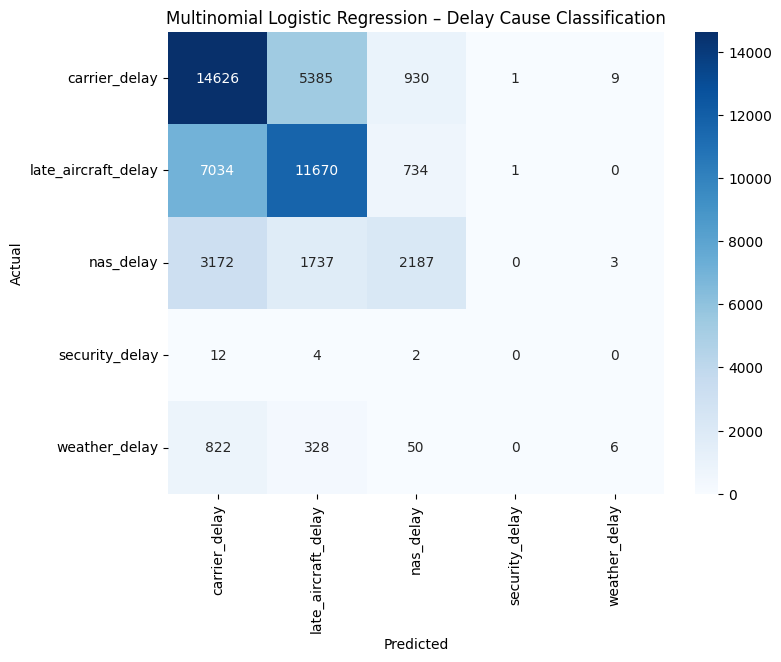

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=model.classes_,
    yticklabels=model.classes_
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Multinomial Logistic Regression – Delay Cause Classification")
plt.show()


In [10]:
y_prob = model.predict_proba(X_test)

prob_df = pd.DataFrame(
    y_prob,
    columns=model.classes_
)

prob_df.head()

,carrier_delay,late_aircraft_delay,nas_delay,security_delay,weather_delay
0,0.683045,0.150279,0.103281,0.000858,0.062536
1,0.378803,0.464081,0.108625,0.000043,0.048449
2,0.220766,0.704094,0.066359,0.000011,0.008771
3,0.653750,0.302225,0.041865,0.000039,0.002121
4,0.644547,0.237269,0.090003,0.000494,0.027688


In [11]:
feature_names = encoder.get_feature_names_out()

coef_df = pd.DataFrame(
    model.coef_,
    columns=feature_names,
    index=model.classes_
)

for cls in coef_df.index:
    print(f"\nTop drivers for {cls}")
    print(
        coef_df.loc[cls]
        .sort_values(key=abs, ascending=False)
        .head(8)
    )



Top drivers for carrier_delay
carrier_HA            1.918190
arr_del15_nan         1.442929
arr_flights_2480.0    1.442687
arr_flights_11.0     -1.433889
arr_flights_7.0      -1.418183
arr_flights_18.0     -1.397003
carrier_VX           -1.368139
arr_flights_16.0     -1.352658
Name: carrier_delay, dtype: float64

Top drivers for late_aircraft_delay
arr_del15_1.0   -2.426696
airport_EWR     -2.349317
arr_del15_2.0   -2.271293
airport_LGA     -2.229854
arr_del15_3.0   -1.993975
arr_del15_4.0   -1.969391
arr_del15_6.0   -1.792470
arr_del15_7.0   -1.787894
Name: late_aircraft_delay, dtype: float64

Top drivers for nas_delay
carrier_HA    -3.607460
airport_EWR    2.661450
airport_LGA    2.627286
airport_SFO    2.420338
airport_ORD    2.216443
airport_JFK    1.941143
airport_PHL    1.908499
airport_WRG   -1.580520
Name: nas_delay, dtype: float64

Top drivers for security_delay
airport_CDB      2.049193
carrier_VX       1.824921
arr_del15_1.0    1.770403
carrier_HA       1.741017
arr_del15_2

In [12]:
errors = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
})

errors = errors[errors["Actual"] != errors["Predicted"]]

errors.head()


,Actual,Predicted
1,carrier_delay,late_aircraft_delay
2,carrier_delay,late_aircraft_delay
5,late_aircraft_delay,carrier_delay
8,late_aircraft_delay,carrier_delay
12,late_aircraft_delay,carrier_delay


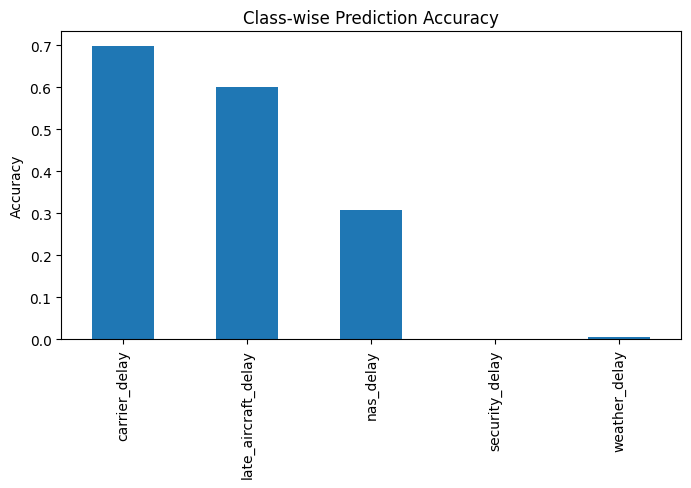

In [13]:
from sklearn.metrics import accuracy_score

class_accuracy = {}

for cls in model.classes_:
    idx = y_test == cls
    class_accuracy[cls] = accuracy_score(
        y_test[idx],
        y_pred[idx]
    )

pd.Series(class_accuracy).plot(
    kind="bar",
    title="Class-wise Prediction Accuracy",
    figsize=(8,4)
)
plt.ylabel("Accuracy")
plt.show()


In [14]:
from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)

baseline_pred = baseline.predict(X_test)

print("Baseline accuracy:",
      (baseline_pred == y_test).mean())

print("Model accuracy:",
      (y_pred == y_test).mean())


Baseline accuracy: 0.43009053024859895
Model accuracy: 0.5848336173095477


In [18]:

prob_matrix = model.predict_proba(X_test)

prob_df = pd.DataFrame(
    prob_matrix,
    columns=model.classes_,
    index=y_test.index
)

delay_cols = [
    "carrier_delay",
    "weather_delay",
    "nas_delay",
    "security_delay",
    "late_aircraft_delay"
]

total_delay = df.loc[y_test.index, delay_cols].sum(axis=1)

expected_contrib = prob_df.multiply(
    total_delay,
    axis=0
)

expected_contrib.head()


,carrier_delay,late_aircraft_delay,nas_delay,security_delay,weather_delay
40788,48.496208,10.669833,7.332936,0.060949,4.440075
193469,378.045315,463.152663,108.407573,0.042483,48.351965
135109,83.449655,266.147350,25.083697,0.003978,3.315321
223665,1884.761922,871.315057,120.697201,0.111943,6.113876
8089,711.579410,261.944634,99.363452,0.545110,30.567394


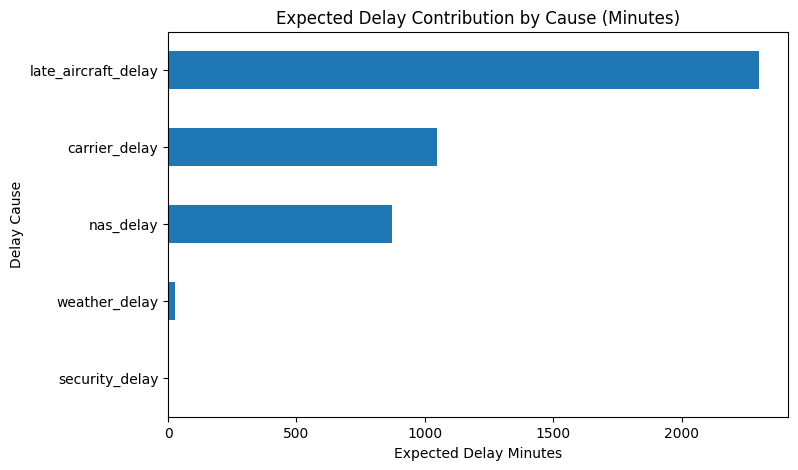

In [19]:
expected_contrib.mean().sort_values().plot(
    kind="barh",
    figsize=(8,5),
    title="Expected Delay Contribution by Cause (Minutes)"
)

plt.xlabel("Expected Delay Minutes")
plt.ylabel("Delay Cause")
plt.show()